# First ICU Prediction using Gradient Boosting Machines

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import interp, stats
import lightgbm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from utils.splits import set_two_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/work_dir/gbm'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'cols': ['class_label', 'scispacy_note'],
 'modeldir': PosixPath('../data/work_dir/gbm/models'),
 'min_freq': 3,
 'bc_threshold': 0.3,
 'start_seed': 127}

## LightGBM Dev

In [3]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
df = set_two_splits(ori_df.copy(), 'test', seed=seed)

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()

In [4]:
parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'num_threads': 32,
    'min_data_in_leaf': 3,
    'num_iterations': 1000,
}

clf = lightgbm.LGBMClassifier(**parameters)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


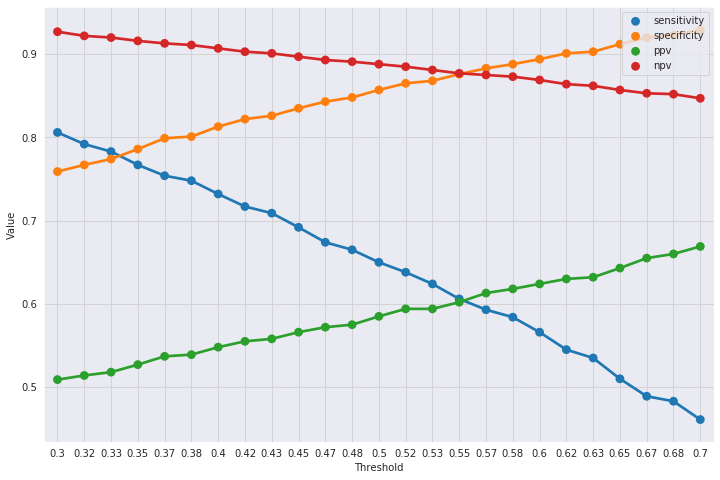

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [6]:
y_pred = (prob > 0.3).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.806
specificity,0.759
ppv,0.509
npv,0.927
f1,0.624
auroc,0.861
prevalence,0.237


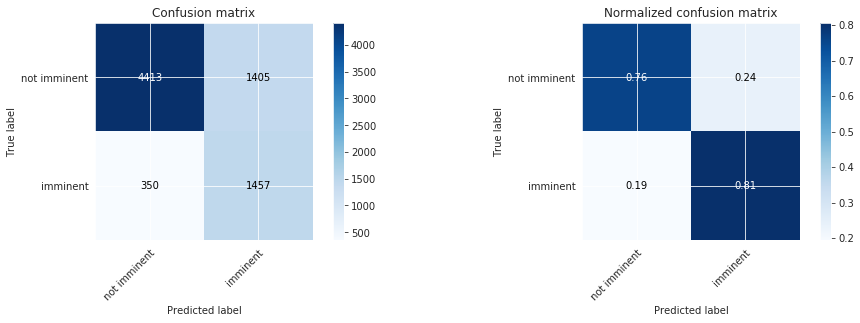

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['not imminent', 'imminent'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

## 100 Seed Run

In [8]:
parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'num_threads': 32,
    'min_data_in_leaf': 3,
    'num_iterations': 1000,
}

In [9]:
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
preds = []
targs = []
probs = []

for seed in range(args.start_seed, args.start_seed + 100):
  if seed % 10 == 0:
    print(f"Running classifier with seed {seed}")
  df = set_two_splits(ori_df.copy(), 'test', seed=seed)
  vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, ngram_range=(2,2))
  
  x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
  x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
  
  y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
  y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()
  targs.append(y_test)
  
  clf = lightgbm.LGBMClassifier(**parameters)
  
  clf.fit(x_train, y_train)  
  pickle.dump(clf, open(args.modeldir/f'gbm_seed_{seed}.pkl', 'wb'))
  
  prob = clf.predict_proba(x_test)[:, 1]
  probs.append(prob)
  
  y_pred = (prob > args.bc_threshold).astype(np.int64)
  preds.append(y_pred)

with open(args.workdir/f'preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Running classifier with seed 130


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 140


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 150


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 160


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 170


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 180


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 190


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 200


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 210


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

Running classifier with seed 220


/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. 

## Metrics

In [10]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'gbm_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]  

In [11]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam

Number of Runs: 100
Average Prevalence of positive class: 0.236

In [12]:
bam.get_avg_metrics()

,Value,Definition
sensitivity,0.818,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.743,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.496,"When it PREDICTS YES, how often is it correct?"
auroc,0.862,Indicates how well the model is capable of distinguishing between classes
npv,0.929,"When it PREDICTS NO, how often is it correct?"
f1,0.618,Harmonic mean of sensitivity and ppv


In [13]:
bam.get_avg_metrics(conf=0.95)

,Lower,Mean,Upper,Confidence,Definition
sensitivity,0.816,0.818,0.820,0.95,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.741,0.743,0.744,0.95,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.494,0.496,0.497,0.95,"When it PREDICTS YES, how often is it correct?"
npv,0.929,0.929,0.930,0.95,"When it PREDICTS NO, how often is it correct?"


In [14]:
get_best_model(bam, fnames)

,Value,Model File
sensitivity,0.841387,gbm_seed_175.pkl
specificity,0.759357,gbm_seed_179.pkl
ppv,0.513940,gbm_seed_188.pkl
auroc,0.872051,gbm_seed_175.pkl
npv,0.940180,gbm_seed_175.pkl
f1,0.632150,gbm_seed_221.pkl


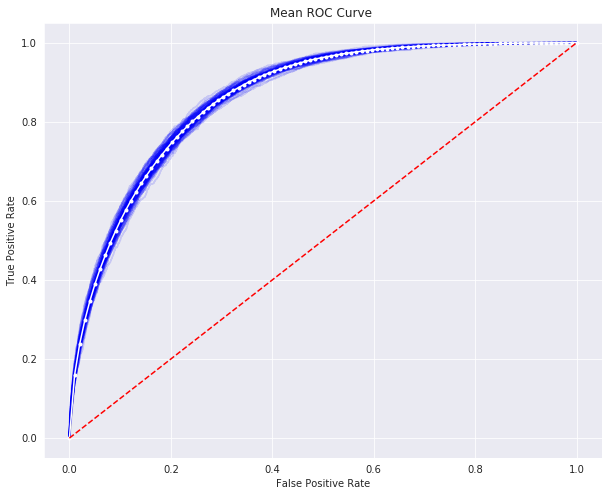

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

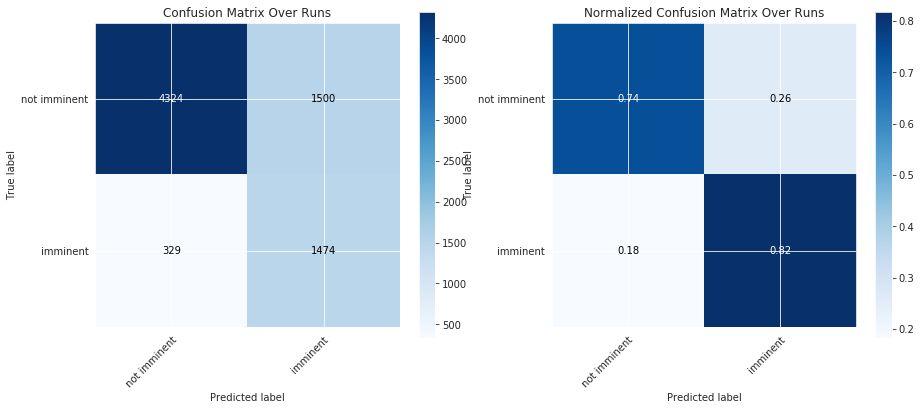

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Data

In [17]:
parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'num_threads': 32,
    'min_data_in_leaf': 3,
    'num_iterations': 1000,
}

In [18]:
pd.read_csv(args.dataset_csv, usecols=args.cols)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2))

x = vectorizer.fit_transform(df['scispacy_note'])
y = df['class_label'].to_numpy()

clf = lightgbm.LGBMClassifier(**parameters)
clf.fit(x, y)
df['prob'] = clf.predict_proba(x)[:, 1]

/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [19]:
with open(args.workdir/'all_data_model.pkl', 'wb') as f:
  pickle.dump(clf, f)
  pickle.dump(vectorizer.vocabulary_, f)